# 18.6 Making Predictions

* Load the **houseprices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [8]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [9]:
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.street, prefix="street", drop_first=True)], axis=1)
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.street, prefix="kitchenqual", drop_first=True)], axis=1)

cat_column_names = list(pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True).columns)
cat_column_names = cat_column_names + list(pd.get_dummies(houses_df.street, prefix="street", drop_first=True).columns)
cat_column_names2 = cat_column_names + list(pd.get_dummies(houses_df.street, prefix="kitchenqual", drop_first=True).columns)

In [10]:
# Y is the target variable
Y = houses_df['saleprice']
# X is the feature set which includes
X = houses_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']  + cat_column_names2]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:03:43   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual       2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea           43.3745      2.745     15.800      0.000      37.988      48.760
garagecars        1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea          17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf         23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV       1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH       7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL       2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM       2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave      -4088.8341   8703.993     -0.470      0.639   -2.12e+04     1.3e+04
kitchenqual_Pave -4088.8341   8703.993     -0.470      0.639   -2.12e+04     1.3e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     9.20e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.55e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

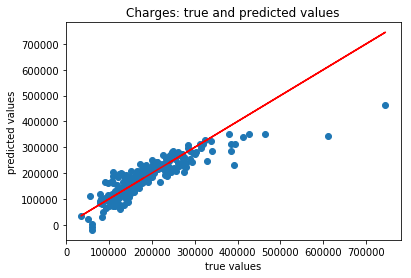

Mean absolute error of the prediction is: 25546.803828588574
Mean squared error of the prediction is: 1559083821.9731004
Root mean squared error of the prediction is: 39485.235493448694
Mean absolute percentage error of the prediction is: 15.55142034753754


In [11]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

As we saw in the previous exercise, a few things can be done to improve this model. We can log transform the target variable to closer resemble normal distribution and we can introduce an interaction term between overallqual and totalbsmtsf. Let's implement these improvements and see how our prediction metrics react.

In [12]:
# create interaction term
houses_df['int_term'] = houses_df['overallqual'] * houses_df['totalbsmtsf']

# Y is the target variable
Y = np.log1p(houses_df['saleprice'])
# X is the feature set which includes
X = houses_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'int_term']  + cat_column_names2]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     517.9
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:05:49   Log-Likelihood:                 461.17
No. Observations:                1168   AIC:                            -898.3
Df Residuals:                    1156   BIC:                            -837.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.9990      0.098    102.358      0.000       9.807      10.191
overallqual          0.1727      0.008     21.682      0.000       0.157       0.188
grlivarea            0.0002   1.19e-05     17.786      0.000       0.000       0.000
garagecars           0.0841      0.015      5.672      0.000       0.055       0.113
garagearea        9.612e-05   5.04e-05      1.908      0.057   -2.71e-06       0.000
totalbsmtsf          0.0004   4.06e-05     10.262      0.000       0.000       0.000
int_term         -4.622e-05   5.56e-06     -8.310      0.000   -5.71e-05   -3.53e-05
mszoning_FV          0.4105      0.065      6.350      0.000       0.284       0.537
mszoning_RH          0.2906      0.074      3.938      0.000       0.146       0.435
mszoning_RL          0.4060      0.060      6.780      0.000       0.289       0.524
mszoning_RM          0.2318      0.061      3.818      0.000       0.113       0.351
street_Pave         -0.0235      0.037     -0.628      0.530      -0.097       0.050
kitchenqual_Pave    -0.0235      0.037     -0.628      0.530      -0.097       0.050
==============================================================================
Omnibus:                      356.207   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2810.085
Skew:                          -1.183   Prob(JB):                         0.00
Kurtosis:                      10.221   Cond. No.                     2.24e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.56e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

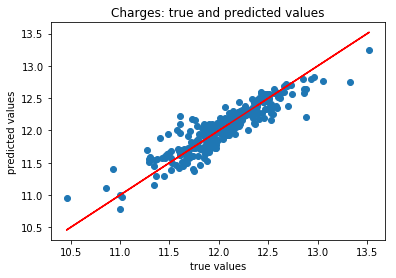

Mean absolute error of the prediction is: 0.12334422039105877
Mean squared error of the prediction is: 0.02835519509107643
Root mean squared error of the prediction is: 0.16839000888139544
Mean absolute percentage error of the prediction is: 1.0303957002999722


In [13]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

As we can see, the second model improves upon every metric from the first. 

Let's try some other variations.

In [14]:
# create interaction term
houses_df['int_term'] = houses_df['overallqual'] * houses_df['totalbsmtsf']

# Y is the target variable
Y = np.log1p(houses_df['saleprice'])
# X is the feature set which includes
X = houses_df[['overallqual', 'grlivarea', 'garagecars','totalbsmtsf', 'garagearea', 'int_term', 'mszoning_RL', 'mszoning_FV']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     701.6
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:09:33   Log-Likelihood:                 452.70
No. Observations:                1168   AIC:                            -887.4
Df Residuals:                    1159   BIC:                            -841.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.1650      0.046    221.841      0.000      10.075      10.255
overallqual     0.1761      0.008     22.123      0.000       0.160       0.192
grlivarea       0.0002   1.19e-05     17.712      0.000       0.000       0.000
garagecars      0.0844      0.015      5.671      0.000       0.055       0.114
totalbsmtsf     0.0004   4.08e-05     10.332      0.000       0.000       0.001
garagearea   8.495e-05   5.03e-05      1.688      0.092   -1.38e-05       0.000
int_term    -4.709e-05   5.59e-06     -8.430      0.000   -5.81e-05   -3.61e-05
mszoning_RL     0.1789      0.014     12.990      0.000       0.152       0.206
mszoning_FV     0.1813      0.027      6.767      0.000       0.129       0.234
==============================================================================
Omnibus:                      356.839   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2690.345
Skew:                          -1.199   Prob(JB):                         0.00
Kurtosis:                      10.038   Cond. No.                     7.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

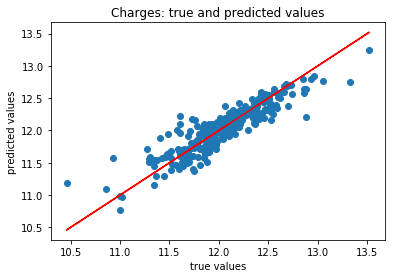

Mean absolute error of the prediction is: 0.12595723001115927
Mean squared error of the prediction is: 0.030292212288299453
Root mean squared error of the prediction is: 0.17404658080036922
Mean absolute percentage error of the prediction is: 1.053764410667414


In [15]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

After removing a few variables, we can see that this model is close to the second, but not quite as successful.